# Point Cloud Classification with PointNet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install trimesh
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [3]:
# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  1


## Download the Dataset

**Run the below cell if you are running this for the first time to download the data**


In [4]:
##Run this first time while downloading the dataset


# DATA_DIR = tf.keras.utils.get_file(
#     "modelnet.zip",
#     "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
#     extract=True,
# )
# DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

**If the dataset is already downloaded, just use the path for the ModelNet10 folder**


In [6]:
#replace this path with the data folder
string_path = "D:/Manoj/ML_Project_Point_Cloud/Datasets/ModelNet10"

# or 
# string_path = "D:/Manoj/ML_Project_Point_Cloud/Datasets/ModelNet40"

# Create a platform-independent path
DATA_DIR = os.path.join(*string_path.split('\\'))
print(DATA_DIR)

D:/Manoj/ML_Project_Point_Cloud/Datasets/ModelNet10


## Visualize a Mesh from the Dataset

In [7]:
# load returns mesh – Loaded geometry data

mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

In [6]:
# trimesh.load(os.path.join(DATA_DIR, "guitar/train/guitar_0013.off")).show()

## Sample a Mesh and Show Result

<class 'trimesh.caching.TrackedArray'>
<class 'trimesh.caching.TrackedArray'>


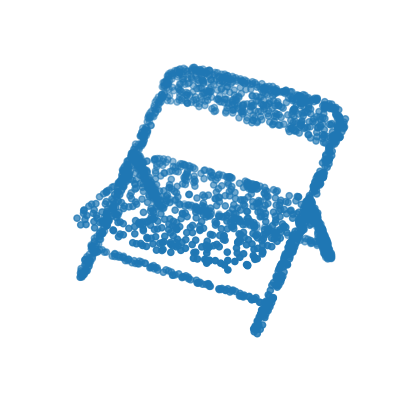

In [21]:
points = mesh.sample(2048)print(type(points))
print(type(points[0]))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

## Function to Parse Data
- Each mesh is loaded and sampled into a point cloud and is returned as a numpy array

In [14]:
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    #this function creates a list kinda object of folder paths inside DATA_DIR
    # folders = glob.glob(os.path.join(DATA_DIR,  '*'))
    # print(len(folders))

    folders = [folder for folder in glob.glob(os.path.join(DATA_DIR, '*')) if os.path.isdir(folder)]
    print(len(folders))
    for i, folder in enumerate(folders):
        
        if not os.path.isdir(folder):  # Check if the path is a directory
            continue  # Skip iteration if it's not a directory
        print("processing class: {}".format(os.path.basename(folder)))
        
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("\\")[-1]# for windows path separator is \\
        
        # print(folder) #
        print( class_map[i]) #label
        
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

## Parse the Dataset and Process each Class

In [15]:
NUM_POINTS = 2048
NUM_CLASSES = 10
BATCH_SIZE = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

10
processing class: bathtub
bathtub
processing class: bed
bed
processing class: chair
chair
processing class: desk
desk
processing class: dresser
dresser
processing class: monitor
monitor
processing class: night_stand
night_stand
processing class: sofa
sofa
processing class: table
table
processing class: toilet
toilet


In [17]:
print(CLASS_MAP)

{0: 'bathtub', 1: 'bed', 2: 'chair', 3: 'desk', 4: 'dresser', 5: 'monitor', 6: 'night_stand', 7: 'sofa', 8: 'table', 9: 'toilet'}


## Augenmentation for Train Dataset

In [22]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [35]:
# Get the directory of the current script or notebook
current_directory = os.getcwd()
print(current_directory)
# Define the path to save the dataset
modelnet10_train_dataset_path = os.path.join(current_directory, "modelnet10_train_dataset")
modelnet10_test_dataset_path = os.path.join(current_directory, "modelnet10_test_dataset")

print(modelnet10_train_dataset_path)
print(modelnet10_test_dataset_path)

D:\Manoj\ML_Project_Point_Cloud
D:\Manoj\ML_Project_Point_Cloud\modelnet10_train_dataset
D:\Manoj\ML_Project_Point_Cloud\modelnet10_test_dataset


## To save the tesnorflow dataset ; to avoid parsing again

In [28]:
train_dataset.save(modelnet10_train_dataset_path)
test_dataset.save(modelnet10_test_dataset_path)

D:\Manoj\ML_Project_Point_Cloud


## To load the required  tf datasets

In [ ]:
train_dataset = tf.data.Dataset.load(modelnet10_train_dataset_path)
test_dataset = tf.data.Dataset.load(modelnet10_test_dataset_path)

## Functions to Build the Model

In [41]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [54]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self):
        return {'l2reg': self.l2reg}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Function to create T-net Layers

In [55]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

## Create the Convolutional Neural Network

In [56]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 2048, 32)     128         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_34 (BatchN  (None, 2048, 32)    128         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 2048, 32)     0           ['batch_normalization_34[0

## Compile and Train the Model

In [57]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(train_dataset, epochs=40, validation_data=test_dataset)

Epoch 1/40
125/125 [==============================] - 9s 51ms/step - loss: 3.6300 - sparse_categorical_accuracy: 0.2538 - val_loss: 19229701046272.0000 - val_sparse_categorical_accuracy: 0.2996
Epoch 2/40
125/125 [==============================] - 6s 49ms/step - loss: 3.0070 - sparse_categorical_accuracy: 0.3954 - val_loss: 17607350550528.0000 - val_sparse_categorical_accuracy: 0.3711
Epoch 3/40
125/125 [==============================] - 6s 47ms/step - loss: 2.6924 - sparse_categorical_accuracy: 0.4981 - val_loss: 1306093713008321626112.0000 - val_sparse_categorical_accuracy: 0.4174
Epoch 4/40
125/125 [==============================] - 6s 47ms/step - loss: 2.5564 - sparse_categorical_accuracy: 0.5377 - val_loss: 675954486377525018624.0000 - val_sparse_categorical_accuracy: 0.4262
Epoch 5/40
125/125 [==============================] - 6s 47ms/step - loss: 2.4784 - sparse_categorical_accuracy: 0.5713 - val_loss: 1356092801024.0000 - val_sparse_categorical_accuracy: 0.5430
Epoch 6/40
125/1

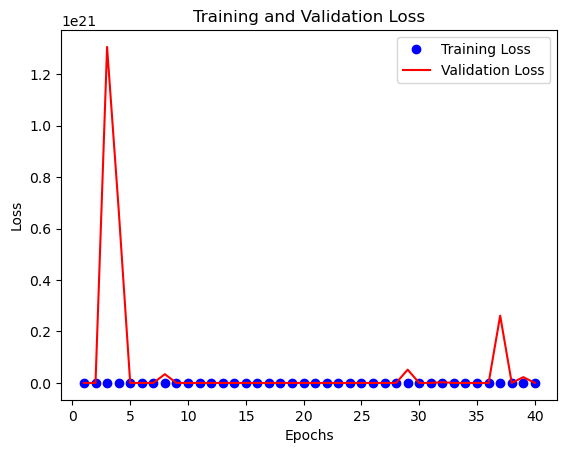

In [70]:
# Plot training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

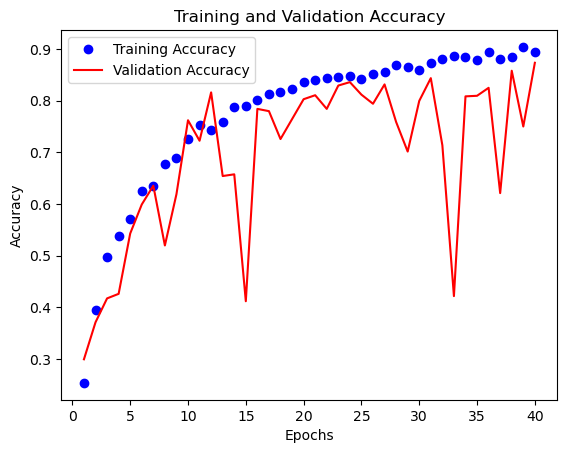

In [71]:

# Plot training and validation accuracy
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Save the model (weights)

In [61]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on new data
# Example: predictions = model.predict(new_data)

# Save the trained model
model.save("modelnet10_trained_model.h5")
model.save("modelnet10_trained_model")
model.save_weights("modelnet10_trained_model_weights.h5")
model.save_weights("modelnet10_trained_model_weights")


29/29 [==============================] - 1s 16ms/step - loss: 410440.4375 - sparse_categorical_accuracy: 0.8733
Test Loss: 410440.4375
Test Accuracy: 0.8733479976654053


INFO:tensorflow:Assets written to: modelnet10_trained_model\assets


INFO:tensorflow:Assets written to: modelnet10_trained_model\assets


## Loading saved model wweights

In [64]:
new_model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
new_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)
new_model.load_weights("modelnet10_trained_model_weights.h5")
test_loss, test_accuracy = new_model.evaluate(test_dataset)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


29/29 [==============================] - 1s 14ms/step - loss: 410441.2812 - sparse_categorical_accuracy: 0.8733
Test Loss: 410441.28125
Test Accuracy: 0.8733479976654053


In [72]:
history = new_model.fit(train_dataset, epochs=5, validation_data=test_dataset)


Epoch 1/5
125/125 [==============================] - 6s 48ms/step - loss: 1.4233 - sparse_categorical_accuracy: 0.8940 - val_loss: 160133113987465216.0000 - val_sparse_categorical_accuracy: 0.7985
Epoch 2/5
125/125 [==============================] - 6s 48ms/step - loss: 1.3640 - sparse_categorical_accuracy: 0.9025 - val_loss: 3556291379200.0000 - val_sparse_categorical_accuracy: 0.8700
Epoch 3/5
125/125 [==============================] - 6s 48ms/step - loss: 1.4032 - sparse_categorical_accuracy: 0.8948 - val_loss: 916239679488.0000 - val_sparse_categorical_accuracy: 0.8634
Epoch 4/5
125/125 [==============================] - 6s 46ms/step - loss: 1.3699 - sparse_categorical_accuracy: 0.9058 - val_loss: 2927354326319890432.0000 - val_sparse_categorical_accuracy: 0.8293
Epoch 5/5
125/125 [==============================] - 6s 47ms/step - loss: 1.3734 - sparse_categorical_accuracy: 0.9085 - val_loss: 215475451223605248.0000 - val_sparse_categorical_accuracy: 0.8029


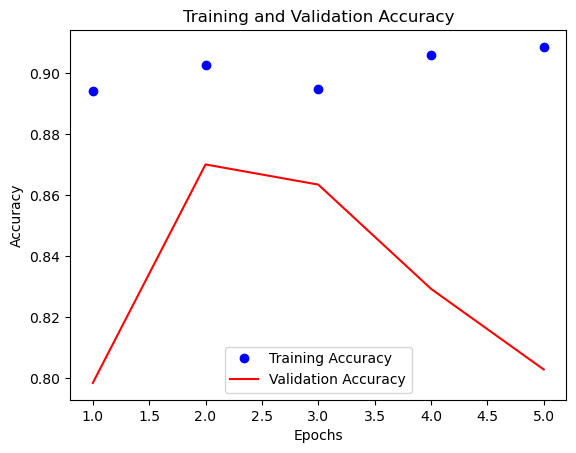

In [73]:
# Plot training and validation accuracy
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visualize The Predictions

1/1 [==============================] - 0s 24ms/step


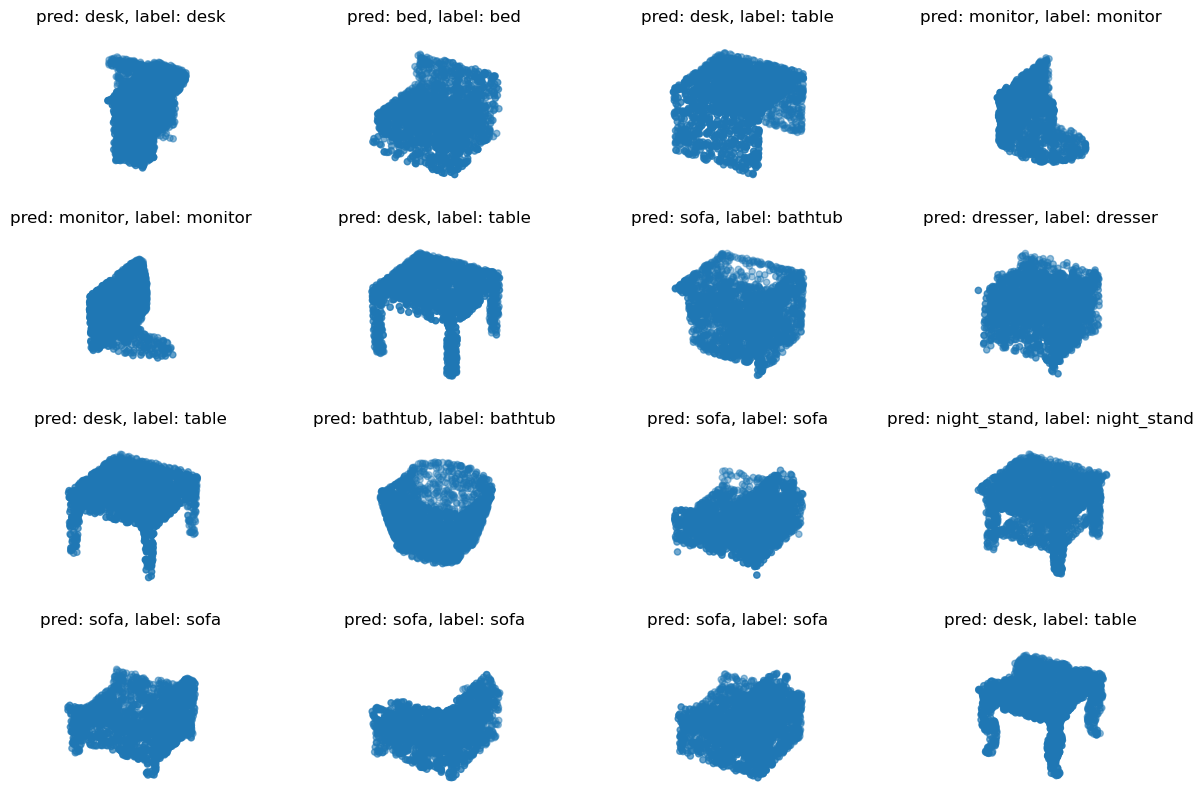

In [77]:
data = test_dataset.take(1)

points, labels = list(data)[0]
test_sample_size = 16
points = points[:test_sample_size, ...]
labels = labels[:test_sample_size, ...]

# run test data through model
preds = model.predict(points)
# preds = new_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(test_sample_size):
    ax = fig.add_subplot(test_sample_size//4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()